# CNN for AED with Keras/TensorFlow (living room)

Date: Nov 8, 2018

Data acquisition: living room

## Preparing data set for CNN

In [2]:
DATASET_FOLDER = '../dataset/data_living/'

%run dataset.py

ds = DataSet(DATASET_FOLDER)
train_data, train_labels, test_data, test_labels = ds.generate()
shape = ds.get_shape()
class_labels = ds.get_class_labels()

### CNN model

In [5]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(*shape, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 38, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 19, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 17, 8)         296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 8, 8)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 6, 16)         1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
__________

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

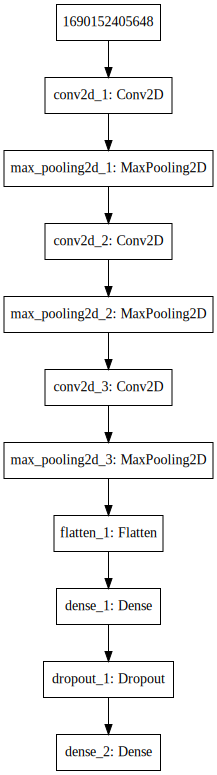

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [8]:
EPOCHS = 30
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels), batch_size=10)

Train on 840 samples, validate on 210 samples
Epoch 1/30
840/840 [==============================] - 7s 8ms/step - loss: 1.7771 - acc: 0.2988 - val_loss: 1.4280 - val_acc: 0.4857
Epoch 2/30
840/840 [==============================] - 5s 7ms/step - loss: 1.2884 - acc: 0.5476 - val_loss: 1.0200 - val_acc: 0.6857
Epoch 3/30
840/840 [==============================] - 6s 7ms/step - loss: 1.0072 - acc: 0.6774 - val_loss: 0.7537 - val_acc: 0.7762
Epoch 4/30
840/840 [==============================] - 5s 6ms/step - loss: 0.8634 - acc: 0.7214 - val_loss: 0.6418 - val_acc: 0.8095
Epoch 5/30
840/840 [==============================] - 6s 7ms/step - loss: 0.7569 - acc: 0.7464 - val_loss: 0.7032 - val_acc: 0.7667
Epoch 6/30
840/840 [==============================] - 5s 7ms/step - loss: 0.6945 - acc: 0.7738 - val_loss: 0.5265 - val_acc: 0.8143
Epoch 7/30
840/840 [==============================] - 5s 6ms/step - loss: 0.6084 - acc: 0.7952 - val_loss: 0.5421 - val_acc: 0.8286
Epoch 8/30
840/840 [==========

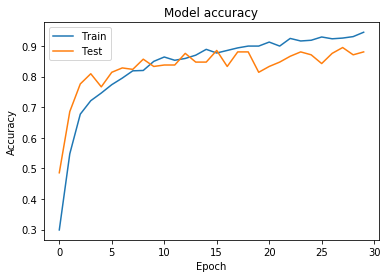

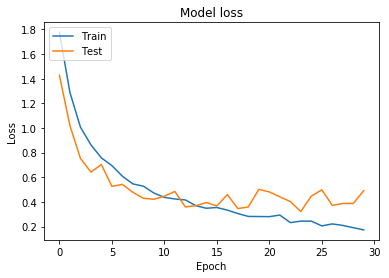

In [9]:
%run history.py
%matplotlib inline

plot_accuracy(history)
plot_loss(history)

## Save the model

In [10]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = DATASET_FOLDER + '/cnn_for_aed_living_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [11]:
del model
model = models.load_model(filename)

## Confirmation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(840, 64, 40, 1)

In [13]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [14]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [15]:
class_labels

['bathing',
 'cocking',
 'moving',
 'silence',
 'tooth_brushing',
 'washing',
 'watching_tv']

In [16]:
(activations[-1][:10]*100).astype(int)

array([[ 0,  0,  0,  0,  0,  0, 99],
       [ 0,  0,  0, 99,  0,  0,  0],
       [ 0,  0,  0,  0, 99,  0,  0],
       [ 0,  0, 99,  0,  0,  0,  0],
       [ 0,  9,  9,  3,  0, 78,  0],
       [ 0,  0,  0,  0, 99,  0,  0],
       [ 0, 13, 45,  5,  0, 34,  1],
       [ 0, 99,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  0,  0,  0, 67],
       [ 0,  0,  0,  0,  0, 99,  0]])

In [17]:
test_labels[:10].astype(int)

array([[0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]])

In [18]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'watching_tv'

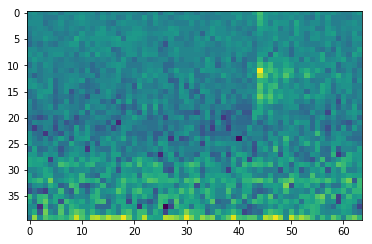

In [19]:
image_number = 8

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

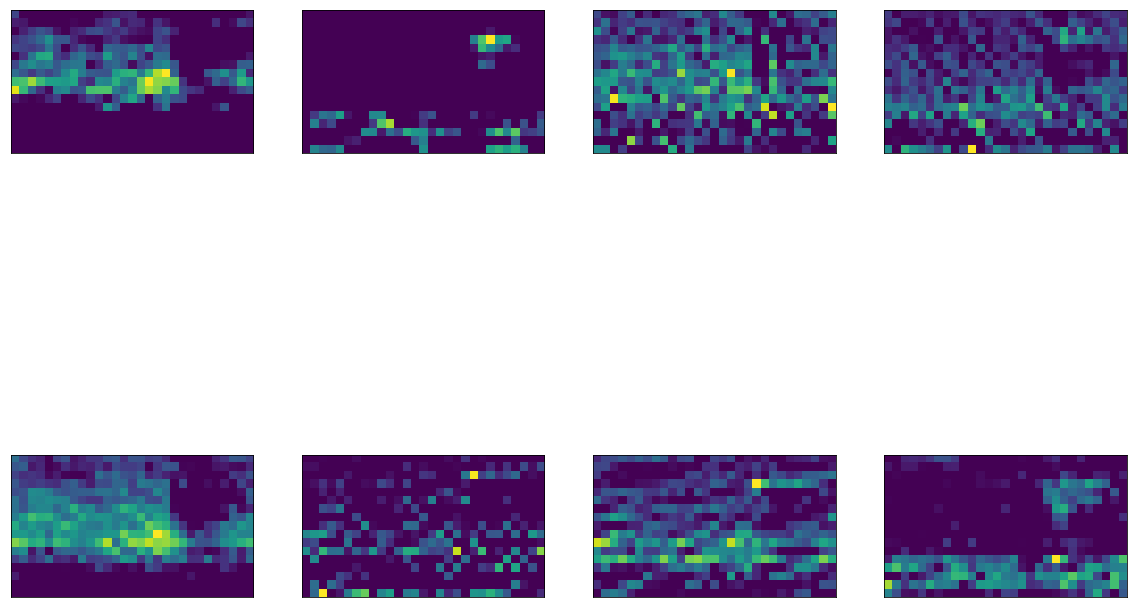

In [20]:
plot_layer(activations, image_number, 2)

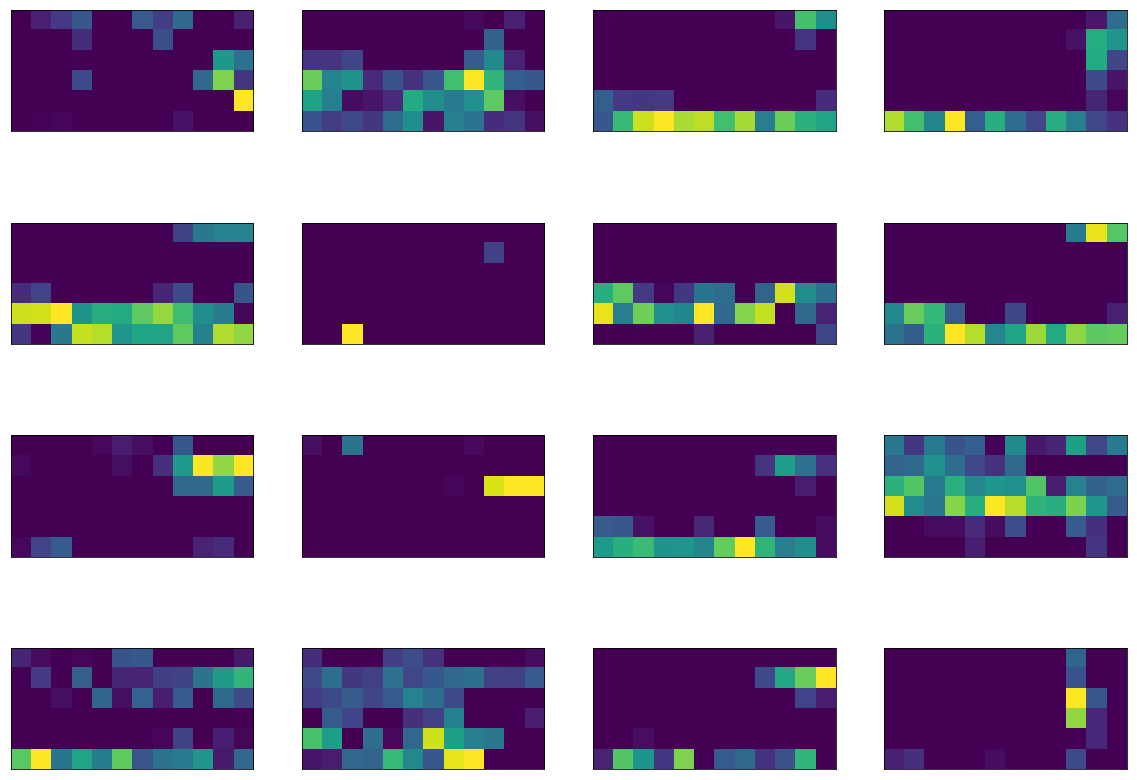

In [21]:
plot_layer(activations, image_number, 4)